<a href="https://colab.research.google.com/github/Mehul-Agrawal410/chatbot/blob/main/transformer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import transformers
import numpy as np
import codecs
import tensorflow as tf
import pandas as pd
import ast
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import warnings
import tensorflow_datasets as tfds
import tensorflow as tf
import joblib
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Progbar
warnings.filterwarnings('ignore')

## Loading cleaned data that I have preprared while EDA and preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
rawData = pd.read_csv('/content/drive/MyDrive/ChatBot-DataSet/twcs.csv/twcs.csv')
company = "AppleSupport"
rawData.head(5)
rawData[rawData['author_id'].str.contains(company)].head(30)

companyAnswers = rawData[rawData['author_id'].str.contains(company)].head(1000)

companyAnswers.head(5)
rawData[rawData['text'].str.contains("@" + company)].tail(20)
answerTweets = []
import numpy as np
import re
for idx, t in companyAnswers[companyAnswers['author_id'].str.contains(company)].iterrows():
     if not np.isnan(t['in_response_to_tweet_id']):

        answerTweets.append(t)

answerTweets[0]['in_response_to_tweet_id']
questionTweets = []

for a in answerTweets:
    question = rawData.loc[rawData['tweet_id'] == a['in_response_to_tweet_id']]
    questionTweets.append(question['text'].to_string(index=False))



for idx, t in enumerate(answerTweets):
    answerTweets[idx] = answerTweets[idx]['text']


#Example answer and matching question
print(answerTweets[2])
print(questionTweets[2])
print(len(answerTweets))
print(len(questionTweets))
qListTemp = []
aListTemp = []

for t in questionTweets:
    t = re.sub('@[^\s]+','',t)
    t = re.sub('http[^\s]+','',t)
    qListTemp.append(t)

for t in answerTweets:
    t = re.sub('@[^\s]+','',t)
    t = re.sub('http[^\s]+','',t)
    aListTemp.append(t)

questionTweets = qListTemp
answerTweets = aListTemp
pairs = list(zip(questionTweets,answerTweets))

questions = [pairs[i][0] for i in range(len(pairs))]
answers = [pairs[i][1] for i in range(len(pairs))]
corpus = {'question': questions, 'answer': answers}

data = pd.DataFrame(corpus)
data.head()

Mounted at /content/drive
@115855 Let's go to DM for the next steps. DM us here: https://t.co/GDrqU22YpT
@AppleSupport Tried resetting my settings .. re...
997
997


,question,answer
0,,We're here for you. Which version of the iOS ...
1,The newest update. I️ made sure t...,Lets take a closer look into this issue. Sele...
2,Tried resetting my settings .. re...,Let's go to DM for the next steps. DM us here:
3,This is what it looks like,Any steps tried since it started last night?
4,I️ have an iPhone 7 Plus and yes ...,That's great it has iOS 11.1 as we can rule o...


## Dividing into TWO, train/validation

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2, random_state=4)

In [ ]:
vocab_ans = list(set(" ".join(train['answer'].values).split()))
vocab_ques = list(set(" ".join(train['question'].values).split()))
vocab_size_ans, vocab_size_ques = len(vocab_ans), len(vocab_ques)
print(f"vocab_size_ans, vocab_size_ques:{vocab_size_ans},{ vocab_size_ques}")

vocab_size_ans, vocab_size_ques:1628,1811


## Using tfds SubwordTextEncoder, it will create tokens
#### example Multiplication -> Multi, pli, cat, i, on
#### Advantages:
    1. Reduces vocab size => faster learning
    2. Reduces chances of missing word in test data

In [ ]:
tokenizer_a = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train['answer'], target_vocab_size=2**15)

tokenizer_q = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train['question'], target_vocab_size=2**15)

In [ ]:
print(f"tokenizer_q:{tokenizer_q.vocab_size}")
print(f"tokenizer_a:{tokenizer_a.vocab_size}")

tokenizer_q:2027
tokenizer_a:1699


#### Examples of subword tokenization in action!

In [ ]:
sample_string = 'Encoder decoder'

tokenized_string = tokenizer_a.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_a.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for token in tokenized_string:
    print(str(token) + "---->" + tokenizer_a.decode([token]))

print("="*80)
tokenized_string = tokenizer_q.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_q.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for token in tokenized_string:
    print(str(token) + "---->" + tokenizer_q.decode([token]))

Tokenized string is [1512, 1553, 1542, 1554, 1543, 1544, 1557, 1475, 1543, 1544, 1542, 1554, 1543, 1544, 1557]
The original string: Encoder decoder
1512---->E
1553---->n
1542---->c
1554---->o
1543---->d
1544---->e
1557---->r
1475----> 
1543---->d
1544---->e
1542---->c
1554---->o
1543---->d
1544---->e
1557---->r
Tokenized string is [1840, 1881, 1870, 1882, 1264, 1885, 1803, 1264, 1870, 1882, 1264, 1885]
The original string: Encoder decoder
1840---->E
1881---->n
1870---->c
1882---->o
1264---->de
1885---->r
1803----> 
1264---->de
1870---->c
1882---->o
1264---->de
1885---->r


###### 0-27512 for questions

###### 0-27357 for answers

* **Attaching token number '27513' representing \<start> and '27514' representing \<end> QUESTIONS**
* **Attaching token number '27358' representing \<start> and '27359' representing \<end> ANSWERS**

In [ ]:
def encode(ques, ans):
    ques = [tokenizer_q.vocab_size] + tokenizer_q.encode(ques.numpy()) + [tokenizer_q.vocab_size+1]
    ans = [tokenizer_a.vocab_size] + tokenizer_a.encode(ans.numpy()) + [tokenizer_a.vocab_size+1]
    return ques, ans

def tf_encode(ques, ans):
    result_ques, result_ans = tf.py_function(encode, [ques, ans], [tf.int64, tf.int64])
    result_ques.set_shape([None])
    result_ans.set_shape([None])
    return result_ques, result_ans

In [ ]:
print(train['question'].values[0],"\n",train['answer'].values[0])
question, answer = tf_encode(train['question'].values[0],train['answer'].values[0])
print(question)
print(answer)

 just updated my 7 plus to 11.1 bu... 
  Got it. Have you updated your Apple Watch to 4.1 yet?
tf.Tensor([2027 1803   32   31    3   60  289    7   10 1817   40  331    1 2028], shape=(14,), dtype=int64)
tf.Tensor(
[1699 1475  187   82    1  132    3  165   15  180  383    2 1495 1489
  123  349 1506 1700], shape=(18,), dtype=int64)


### Creating train_dataset/test_dataset object from Dataframe + padding

###### prefetch: If I'm at epoch-20 then prefetch prepares the Batch for epoch-21, so when epoch-21 start, it will make available the batch in no time, basically enhancing speed

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(dict(train))
train_dataset = train_dataset.map(lambda x:tf_encode(x['question'], x['answer']))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(20000).padded_batch(64, padded_shapes=([None],[None]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices(dict(validation))
val_dataset = val_dataset.map(lambda x:tf_encode(x['question'], x['answer']))
val_dataset = val_dataset.padded_batch(64, padded_shapes=([None],[None]))

In [ ]:
question, answer = next(iter(train_dataset))
question

<tf.Tensor: shape=(64, 16), dtype=int64, numpy=
array([[2027, 1803,  170, ...,    0,    0,    0],
       [2027,    4,  100, ...,    0,    0,    0],
       [2027, 1803,   95, ...,    0,    0,    0],
       ...,
       [2027, 1803,    2, ..., 2028,    0,    0],
       [2027, 1803,  355, ...,    1, 2028,    0],
       [2027, 1803,  473, ...,    0,    0,    0]])>

### Positional encoding function where 'i' -> embedding dimn index, 'pos' -> word index in a sentence

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

(1, 50, 512)


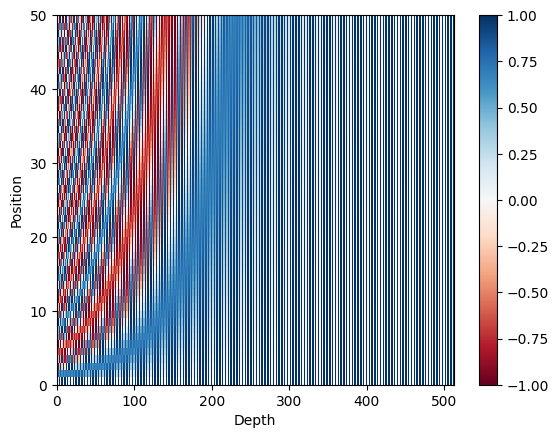

In [ ]:
# Positional encoding


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates



def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis,:]

    return tf.cast(pos_encoding, dtype=tf.float32)



pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 1. Pad Masking
#### Making all the padded tokens, self attention/attention calculation of a word with those paddings will be ignored


* Here output dimn -> (batch_size, 1, 1, seq_len)
          
*  for each 8 attention heads, for each query word it will be multiplied, thats why creating 1, 1 in the middle

##### (batch_size, 8, query_word_len, seq_len) * (batch_size, 1, 1, seq_len)

In [ ]:
# Masking

'''Mask all the pad tokens in the batch of sequence.
It ensures that the model does not treat padding as the input.
The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.
'''
def create_padding_mask(seq):
    """
    seq: padded sentence length (5)
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Adding 2, 3 dimn using tf.newaxis, 2-> As this mask will be multiplied with each attention head and 3-> for each word in a sentance
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
# create_padding_mask(np.array([[1,2,3,0,0,0],[1,2,3,0,0,1]]))

## 2. Looakahead mask

for the first word, its self attention calculation with be ignored will proceeding words i.e. second, third word and so on

In [ ]:
# Looakahead mask

"""The look-ahead mask is used to mask the future tokens in a sequence.
In other words, the mask indicates which entries should not be used.
"""
def create_look_ahead_mask(size):
    """
    The look-ahead mask is used to mask the future tokens in a sequence
    """
    #band_part with this setting creates lower triangular matrix that's why subtracting from 1
    # [[0., 1., 1.],
    #  [0., 0., 1.],
    #  [0., 0., 0.]] output with size:3
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

#example
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## 3. SELF-ATTENTION calculation

![image](images/attenion_formula.png)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Args:
    q: query shape == (..., seq_len_q, depth) # NOTE: depth=dk
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # scale matmul_qk. underroot d_model i.e. underroot(100)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # -1e9 ~ (-INFINITY) => where ever mask is set, make its logit value close to -INF
    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## 4. MultiHeadAttention Calculation
#### Its nothing but a RESHAPING
example :
1. if we have (64, 10, 512)->(BATCH, #words, embeddding) as input, after passiing it though dense layer of size 512 we will get (64, 10, 512)
2. We have three such dense layers representing/for Q, K, V encodings.
3. (64, 10, 512) -> reshape -> (64, 8, 10 ,64) -> (BATCH, attention head, #words, encode)
    '64' is representing encoding of 512 -> 64 dimension
4. (64, 8, 10 ,64)->self-attention-code->(64, 8, 10 ,10) called attention weights, (64, 8, 10 ,64)
5. Concatenate such that 8*64 will be new dimension -> (64, 10, 512)
    
    **Beware embedding dimn must be divisible by no. of heads and always embedding_dimn/heads => encodin_dimn(here 64)**
    
    **NICE HACK** (-_-)

![image](images/multi_head.png)

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model  # typically 512

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

## 5. ENCODER layer



![image](images/encoder_layer.png)


In [ ]:
def point_wise_feed_forward_network(d_model, dff): #dff = 512
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model) # with Attention

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model) #with Attention

        return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

## 6. DECODER LAYER


![image](images/decoder_layer.png)

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

## 7. ENCODER


![image](images/encoder.png)

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]   #x:(batch, seq_len)
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

## 8. DECODER


![image](images/decoder.png)

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

## 9. TRANSFORMER




![image](images/transformer.png)


In [ ]:

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

#### So to create a transformer architecture which is now everywhere in NLP models, we require only 9 STEPs :-O

In [ ]:
# tokenizer_a = joblib.load("tokenizer_a")
# tokenizer_q = joblib.load("tokenizer_q")

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1

transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size,
                          pe_input = input_vocab_size, pe_target = target_vocab_size)

## Custom learning rate, proposed in the paper
#### First learning rate will be high and then after some epochs it will be decreasing ONLY

![image](images/lr.png)


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

### See, increasing and then decreasing

Text(0.5, 0, 'Train Step')

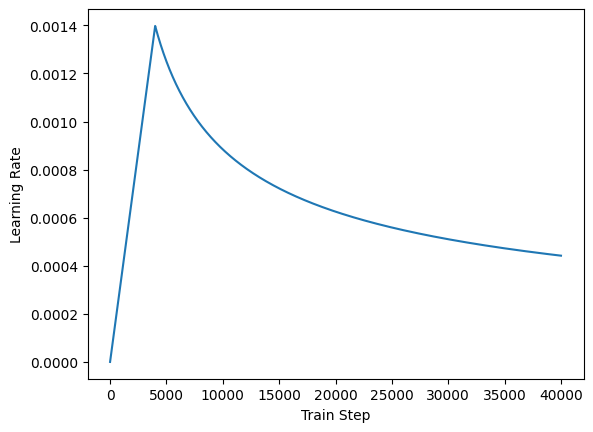

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

##### Custom losss function, same as sparse categorical cross entropy but considers only no padded values

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

### Creating pad mask(encoder), pad mask(decoder), lookahead mask(decoder)

In [ ]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

## Saving model checkpoint

In [ ]:
checkpoint_path = "./checkpoints_test/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

## Creating sample transformer to know the no. of trainable parameters

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1

sample_transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

temp_input = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)
sample_transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  1052800   
                                                                 
 decoder_1 (Decoder)         multiple                  1276032   
                                                                 
 dense_135 (Dense)           multiple                  219429    
                                                                 
Total params: 2548261 (9.72 MB)
Trainable params: 2548261 (9.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1


transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [ ]:
EPOCHS = 20
batch_size = 64
metrics_names = ['loss', 'acc']
train_loss.reset_states()
train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 1/20
832/797 [===============================] - 41s 49ms/step - loss: 7.5240 - acc: 6.1026e-05

epoch 2/20
832/797 [===============================] - 3s 3ms/step - loss: 7.4963 - acc: 9.3708e-05

epoch 3/20
832/797 [===============================] - 3s 3ms/step - loss: 7.4509 - acc: 4.0680e-04

epoch 4/20
832/797 [===============================] - 3s 4ms/step - loss: 7.3984 - acc: 0.0036

epoch 5/20
832/797 [===============================] - 2s 2ms/step - loss: 7.3486 - acc: 0.0071
Saving checkpoint for epoch 5 at ./checkpoints_test/train/ckpt-1

epoch 6/20
832/797 [===============================] - 2s 2ms/step - loss: 7.3024 - acc: 0.0094

epoch 7/20
832/797 [===============================] - 2s 2ms/step - loss: 7.2589 - acc: 0.0111

epoch 8/20
832/797 [===============================] - 2s 2ms/step - loss: 7.2172 - acc: 0.0123

epoch 9/20
832/797 [===============================] - 2s 3ms/step - loss: 7.1768 - acc: 0.0133

epoch 10/20
832/797 [==========================

In [ ]:
EPOCHS = 5
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 1/5
832/797 [===============================] - 1s 1ms/step - loss: 6.5925 - acc: 0.0279

epoch 2/5
832/797 [===============================] - 1s 1ms/step - loss: 6.5383 - acc: 0.0299

epoch 3/5
832/797 [===============================] - 1s 1ms/step - loss: 6.4835 - acc: 0.0320

epoch 4/5
832/797 [===============================] - 1s 1ms/step - loss: 6.4287 - acc: 0.0342

epoch 5/5
832/797 [===============================] - 1s 2ms/step - loss: 6.3738 - acc: 0.0365
Saving checkpoint for epoch 5 at ./checkpoints_test/train/ckpt-5


In [ ]:
MAX_LENGTH = 27
def evaluate(inp_sentence):
    start_token = [tokenizer_q.vocab_size]
    end_token = [tokenizer_q.vocab_size + 1]

    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_q.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_a.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
#         print(predictions.shape,"aa",predictions[: ,-1:, :].shape)
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
#         print(predicted_id, output)
    # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_a.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
inp_sentence = "i am doing great"
a, b = evaluate(inp_sentence)

# RESULTS are ABSURD

In [ ]:
for i in a[1:]:
    print(tokenizer_a.decode([i]))

 
We
'
d 
to 
to 
us 
to 
us 
to 
us 
us 
to 
us 
to 
. 


 ## Lets try with different hyperparameters

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1
temp_input = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)
sample_transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  1052800   
                                                                 
 decoder_1 (Decoder)         multiple                  1276032   
                                                                 
 dense_135 (Dense)           multiple                  219429    
                                                                 
Total params: 2548261 (9.72 MB)
Trainable params: 2548261 (9.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
num_layers = 2
d_model = 256
dff = 512
num_heads = 8
input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1

sample_transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

temp_input = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)
sample_transformer.summary()

Model: "transformer_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  1573632   
                                                                 
 decoder_3 (Decoder)         multiple                  2017024   
                                                                 
 dense_233 (Dense)           multiple                  437157    
                                                                 
Total params: 4027813 (15.36 MB)
Trainable params: 4027813 (15.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Now the trainable parameters has increased from 12M to 24M, Lets test this!!

In [ ]:
EPOCHS = 20
batch_size = 64
metrics_names = ['loss', 'acc']
train_loss.reset_states()
train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 1/20
832/797 [===============================] - 1s 2ms/step - loss: 4.9469 - acc: 0.0956

epoch 2/20
832/797 [===============================] - 1s 1ms/step - loss: 4.8990 - acc: 0.0978

epoch 3/20
832/797 [===============================] - 1s 1ms/step - loss: 4.8460 - acc: 0.0997

epoch 4/20
832/797 [===============================] - 1s 1ms/step - loss: 4.7914 - acc: 0.1027

epoch 5/20
832/797 [===============================] - 1s 1ms/step - loss: 4.7377 - acc: 0.1064
Saving checkpoint for epoch 5 at ./checkpoints_test/train/ckpt-6

epoch 6/20
832/797 [===============================] - 1s 1ms/step - loss: 4.6830 - acc: 0.1096

epoch 7/20
832/797 [===============================] - 1s 1ms/step - loss: 4.6287 - acc: 0.1126

epoch 8/20
832/797 [===============================] - 1s 2ms/step - loss: 4.5757 - acc: 0.1156

epoch 9/20
832/797 [===============================] - 2s 2ms/step - loss: 4.5211 - acc: 0.1183

epoch 10/20
832/797 [===============================] - 1s 1m

In [ ]:
EPOCHS = 30
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 1/30
832/797 [===============================] - 1s 1ms/step - loss: 3.9269 - acc: 0.1484

epoch 2/30
832/797 [===============================] - 1s 1ms/step - loss: 3.8835 - acc: 0.1503

epoch 3/30
832/797 [===============================] - 1s 1ms/step - loss: 3.8415 - acc: 0.1521

epoch 4/30
832/797 [===============================] - 1s 1ms/step - loss: 3.8000 - acc: 0.1541

epoch 5/30
832/797 [===============================] - 1s 1ms/step - loss: 3.7593 - acc: 0.1559
Saving checkpoint for epoch 5 at ./checkpoints_test/train/ckpt-10

epoch 6/30
832/797 [===============================] - 1s 1ms/step - loss: 3.7194 - acc: 0.1579

epoch 7/30
832/797 [===============================] - 1s 1ms/step - loss: 3.6808 - acc: 0.1596

epoch 8/30
832/797 [===============================] - 1s 1ms/step - loss: 3.6431 - acc: 0.1615

epoch 9/30
832/797 [===============================] - 2s 2ms/step - loss: 3.6056 - acc: 0.1635

epoch 10/30
832/797 [===============================] - 2s 2

## Learning is slow, but not stagnant (-__-)

In [ ]:
EPOCHS = 100
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(50, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 51/100
832/797 [===============================] - 1s 1ms/step - loss: 2.9351 - acc: 0.1992

epoch 52/100
832/797 [===============================] - 1s 2ms/step - loss: 2.9095 - acc: 0.2007

epoch 53/100
832/797 [===============================] - 1s 1ms/step - loss: 2.8844 - acc: 0.2024

epoch 54/100
832/797 [===============================] - 1s 1ms/step - loss: 2.8596 - acc: 0.2039

epoch 55/100
832/797 [===============================] - 1s 1ms/step - loss: 2.8348 - acc: 0.2054
Saving checkpoint for epoch 55 at ./checkpoints_test/train/ckpt-16

epoch 56/100
832/797 [===============================] - 1s 1ms/step - loss: 2.8104 - acc: 0.2069

epoch 57/100
832/797 [===============================] - 1s 1ms/step - loss: 2.7864 - acc: 0.2084

epoch 58/100
832/797 [===============================] - 1s 1ms/step - loss: 2.7625 - acc: 0.2099

epoch 59/100
832/797 [===============================] - 1s 1ms/step - loss: 2.7391 - acc: 0.2113

epoch 60/100
832/797 [===================

In [ ]:
EPOCHS = 150
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(100, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 101/150
832/797 [===============================] - 1s 972us/step - loss: 1.9104 - acc: 0.2718

epoch 102/150
832/797 [===============================] - 1s 2ms/step - loss: 1.8945 - acc: 0.2732

epoch 103/150
832/797 [===============================] - 1s 2ms/step - loss: 1.8788 - acc: 0.2746

epoch 104/150
832/797 [===============================] - 1s 1ms/step - loss: 1.8632 - acc: 0.2759

epoch 105/150
832/797 [===============================] - 1s 947us/step - loss: 1.8479 - acc: 0.2772
Saving checkpoint for epoch 105 at ./checkpoints_test/train/ckpt-26

epoch 106/150
832/797 [===============================] - 1s 1ms/step - loss: 1.8327 - acc: 0.2784

epoch 107/150
832/797 [===============================] - 1s 1ms/step - loss: 1.8177 - acc: 0.2796

epoch 108/150
832/797 [===============================] - 1s 957us/step - loss: 1.8030 - acc: 0.2808

epoch 109/150
832/797 [===============================] - 1s 1ms/step - loss: 1.7884 - acc: 0.2821

epoch 110/150
832/797 [==

In [ ]:
EPOCHS = 200
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(150, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 151/200
832/797 [===============================] - 1s 986us/step - loss: 1.3231 - acc: 0.3202

epoch 152/200
832/797 [===============================] - 1s 999us/step - loss: 1.3149 - acc: 0.3209

epoch 153/200
832/797 [===============================] - 1s 959us/step - loss: 1.3068 - acc: 0.3215

epoch 154/200
832/797 [===============================] - 1s 1ms/step - loss: 1.2987 - acc: 0.3222

epoch 155/200
832/797 [===============================] - 1s 1ms/step - loss: 1.2908 - acc: 0.3228
Saving checkpoint for epoch 155 at ./checkpoints_test/train/ckpt-36

epoch 156/200
832/797 [===============================] - 1s 957us/step - loss: 1.2831 - acc: 0.3234

epoch 157/200
832/797 [===============================] - 1s 2ms/step - loss: 1.2753 - acc: 0.3241

epoch 158/200
832/797 [===============================] - 1s 1ms/step - loss: 1.2677 - acc: 0.3248

epoch 159/200
832/797 [===============================] - 1s 1ms/step - loss: 1.2601 - acc: 0.3254

epoch 160/200
832/797 [

In [ ]:
EPOCHS = 300
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(200, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 201/300
832/797 [===============================] - 1s 2ms/step - loss: 1.0092 - acc: 0.3458

epoch 202/300
832/797 [===============================] - 1s 1ms/step - loss: 1.0045 - acc: 0.3462

epoch 203/300
832/797 [===============================] - 1s 1ms/step - loss: 0.9998 - acc: 0.3466

epoch 204/300
832/797 [===============================] - 1s 942us/step - loss: 0.9952 - acc: 0.3470

epoch 205/300
832/797 [===============================] - 1s 1ms/step - loss: 0.9906 - acc: 0.3474
Saving checkpoint for epoch 205 at ./checkpoints_test/train/ckpt-46

epoch 206/300
832/797 [===============================] - 1s 953us/step - loss: 0.9860 - acc: 0.3478

epoch 207/300
832/797 [===============================] - 1s 959us/step - loss: 0.9815 - acc: 0.3481

epoch 208/300
832/797 [===============================] - 1s 950us/step - loss: 0.9771 - acc: 0.3485

epoch 209/300
832/797 [===============================] - 1s 971us/step - loss: 0.9726 - acc: 0.3489

epoch 210/300
832/797

In [ ]:
EPOCHS = 350
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(300, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 301/350
832/797 [===============================] - 1s 1ms/step - loss: 0.6896 - acc: 0.3720

epoch 302/350
832/797 [===============================] - 1s 960us/step - loss: 0.6874 - acc: 0.3721

epoch 303/350
832/797 [===============================] - 1s 970us/step - loss: 0.6853 - acc: 0.3723

epoch 304/350
832/797 [===============================] - 1s 1ms/step - loss: 0.6832 - acc: 0.3725

epoch 305/350
832/797 [===============================] - 1s 1ms/step - loss: 0.6811 - acc: 0.3727
Saving checkpoint for epoch 305 at ./checkpoints_test/train/ckpt-66

epoch 306/350
832/797 [===============================] - 1s 1ms/step - loss: 0.6790 - acc: 0.3729

epoch 307/350
832/797 [===============================] - 1s 1ms/step - loss: 0.6769 - acc: 0.3730

epoch 308/350
832/797 [===============================] - 1s 969us/step - loss: 0.6748 - acc: 0.3732

epoch 309/350
832/797 [===============================] - 1s 937us/step - loss: 0.6727 - acc: 0.3733

epoch 310/350
832/797 [

# EPOCH:350, I think its enough, let's check what type of REPLIES that CHATBOT is generating

In [ ]:
# joblib.dump(tokenizer_q, "tokenizer_q")
# joblib.dump(tokenizer_a, "tokenizer_a")
transformer.save_weights('transformer_model/weights')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}
    sentence = sentence.split(" ")
    predicted_sentence = predicted_sentence.split(" ")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)



def plot_attention_weights(attention,tokenizer_q, tokenizer_a, sentence, result, layer):

    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_q.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)
    #(1, 8, 5, 4) --> (8, 5, 4)
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights [:-1, :]
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)-1))

        ax.set_ylim(len(result)-1.5, -0.5)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        x = ['<start>']+[tokenizer_q.decode([i]) for i in sentence]+['<end>']
        y = [tokenizer_a.decode([i]) for i in result if i < tokenizer_a.vocab_size]
        ax.set_xticklabels([''] + x, fontdict=fontdict, rotation=90)
        ax.set_yticklabels([''] + y, fontdict=fontdict)


        ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()
    plt.show()


MAX_LENGTH = 27

def evaluate(inp_sentence, model,  tokenizer_q, tokenizer_a):
    start_token = [tokenizer_q.vocab_size]
    end_token = [tokenizer_q.vocab_size + 1]

    # All questions has the start and end token
    inp_sentence = start_token + tokenizer_q.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # 'answers' start token : 27358
    decoder_input = [tokenizer_a.vocab_size]
    decoder_input = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = model(encoder_input,
                                                     decoder_input,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_a.vocab_size+1:
            print(f"=============\nGot end token\n=============")
            return tf.squeeze(decoder_input, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)

    return tf.squeeze(decoder_input, axis=0), attention_weights

In [ ]:
def reply(sentence, transformer,  tokenizer_q, tokenizer_a, plot=''):
    result, attention_weights = evaluate(sentence, transformer,  tokenizer_q, tokenizer_a)
#     print("Attention_Blocks:", list(attention_weights.keys()))
    predicted_sentence = tokenizer_a.decode([i for i in result
                                            if i < tokenizer_a.vocab_size])

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
    if plot:
        plot_attention_weights(attention_weights,tokenizer_q, tokenizer_a, sentence, result, plot)
    return sentence, predicted_sentence

Got end token
Input: i was told ten thousand in each pack
Predicted translation:  We'll be happy to take a look into this with you. Here's a link to join us in DM. 


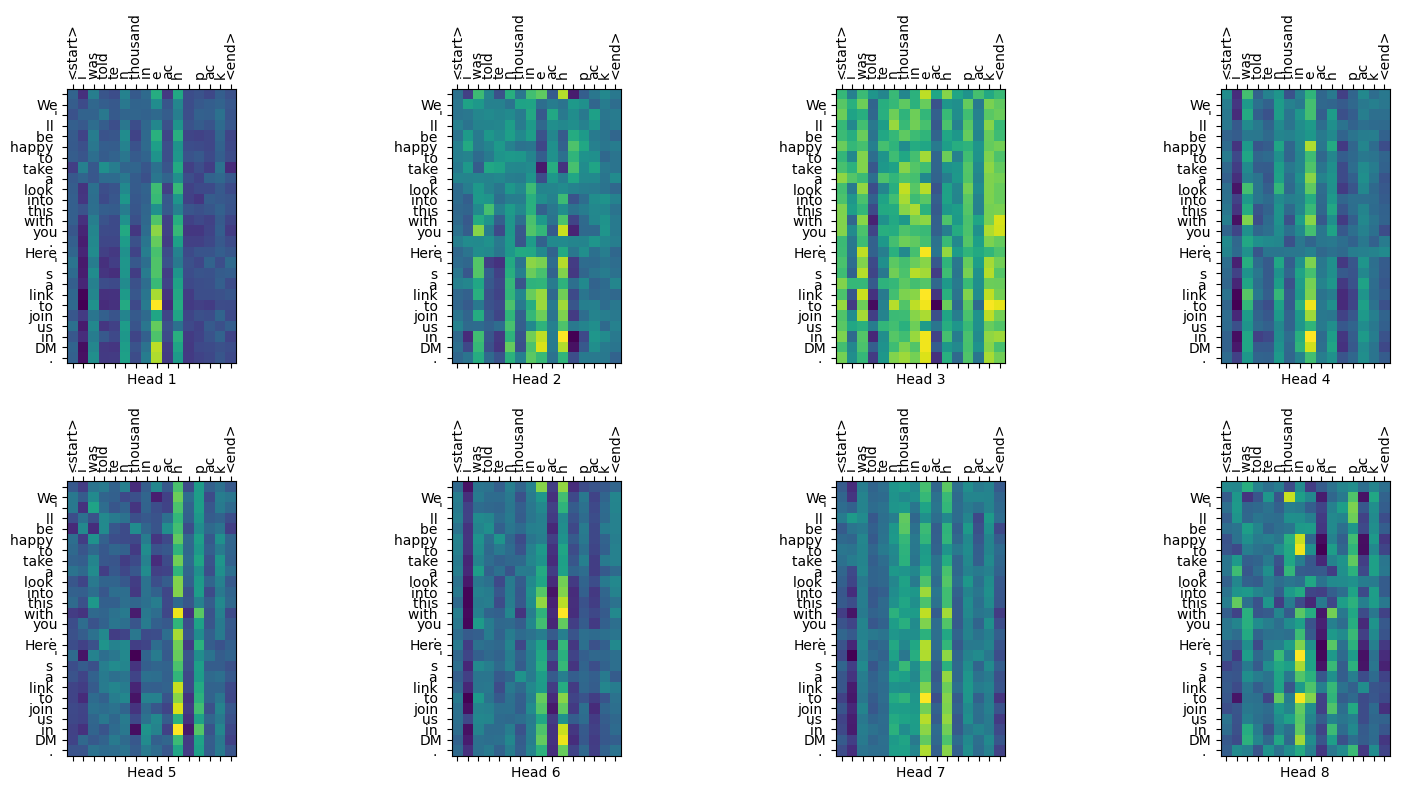

('i was told ten thousand in each pack',
 " We'll be happy to take a look into this with you. Here's a link to join us in DM. ")

In [ ]:
inp_sentence = "i was told ten thousand in each pack"
reply(inp_sentence, transformer,  tokenizer_q, tokenizer_a, "decoder_layer2_block2")

## OUTPUTS are not absurd at all, It has LEARNED

In [ ]:
inp_sentence = "i did not sleep well"
reply(inp_sentence, transformer,  tokenizer_q, tokenizer_a)

Input: i did not sleep well
Predicted translation:  We'd be happy to look into this with you. Please DM us using the link below and we'll go from there


('i did not sleep well',
 " We'd be happy to look into this with you. Please DM us using the link below and we'll go from there")

In [ ]:
train.iloc[400:406]

,question,answer
659,charging my phone but it’s reduci...,We'd like to help you with this. Are you usin...
91,Come on #ios11.1 Same bug as bef...,Let's investigate this together. Does this on...
292,Yayz 11.1 and just 2 English and ...,Thank you! Is this issue only occurring in me...
150,only 8 attempts to open the twitt...,We'd like to look into this with you. Please ...
793,So I thought Apple still doesn’t ...,Thanks for reaching out. Send us a DM and we'...
82,11.1?? when did that come out lol...,It was released earlier today. Let's use thes...


In [ ]:
validation.iloc[400:406]

,question,answer


In [ ]:
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
test_q = train["question"].values[:10]
test_a = train["answer"].values[:10]
bss = []
for i in range(10):
    input_test_sentence = test_q[i]
    input_sentence, pred_string = reply(input_test_sentence, transformer,  tokenizer_q, tokenizer_a, plot='')
    print("Actual:", test_a[i])
    reference = [test_a[i].split()] # the original
    translation = pred_string.split() # trasilated using model
#     bs = bleu.sentence_bleu(reference, translation)
#     bss.append(bs)


Got end token
Input:  just updated my 7 plus to 11.1 bu...
Predicted translation:  Got it. Have you updated your Apple Watch to 4.1 yet?
Actual:  Got it. Have you updated your Apple Watch to 4.1 yet?
Got end token
Input:  7 Plus and 11.0.3
Predicted translation:  Install our newest iOS 11.1 update to help:  Let us know if this helps improve these issues.
Actual:  Install our newest iOS 11.1 update to help:  Let us know if this helps improve these issues.
Got end token
Input:  Thanks for the prompt reply. Scar...
Predicted translation:  OK. Feel free to send us a DM if you still have questions.
Actual:  OK. Feel free to send us a DM if you still have questions.
Input:  The latest one.
Predicted translation:  We want to look into this further with you. Can you send us a DM and let us know the device model you're 
Actual:  We want to look into this further with you. Can you send us a DM and let us know the device model you're using? 
Got end token
Input:   any suggestions???
Predicted tra

In [ ]:
num_layers = 2
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1

load_transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)
load_transformer.load_weights('transformer_model/weights')

In [ ]:
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
test_q = validation["question"].values[100:110]
test_a = validation["answer"].values[100:110]
bss = []
for i in range(10):
    input_test_sentence = test_q[i]
    input_sentence, pred_string = reply(input_test_sentence, load_transformer,  tokenizer_q, tokenizer_a, plot='')
    print("Actual:", test_a[i])
    reference = [test_a[i].split()] # the original
    translation = pred_string.split() # trasilated using model

Input:   APPLE WHY IS MY “I️’s” co...
Predicted translation:  We'd like to see whatupdated. Does this issue mean into your photos?  mean into your iPhone? Which use. Can 
Actual:  Hi. We are here to help. What version of iOS do you have?
Got end token
Input:  This is self explanatory screen s...
Predicted translation:  Thankstell assistanceinto getting tried where other apps updated assistance? Also, mean reset using under Safari noticed other assistance?
Actual:  Let's see if updating the iPhone to iOS 11.1 helps. DM us if it doesn't.  
Input: Got burned and scarred with my magsafe charger ...
Predicted translation:  We're experiencing. Please send ask where this heat seems originate on this issue? Reply those screenshots. DM with tell us if 
Actual:  We want to look into this with you. Send us a DM letting us know more about what happened. 
Input: Please fix the battery issues in Ios 11! 
Predicted translation:  We'd like to take a closer look into this troubleshootingcan can be happ

Got end token
Input: i was told ten thousand in each pack
Predicted translation:  We're using are &amp; 11.1 software version are you noticed other issues?


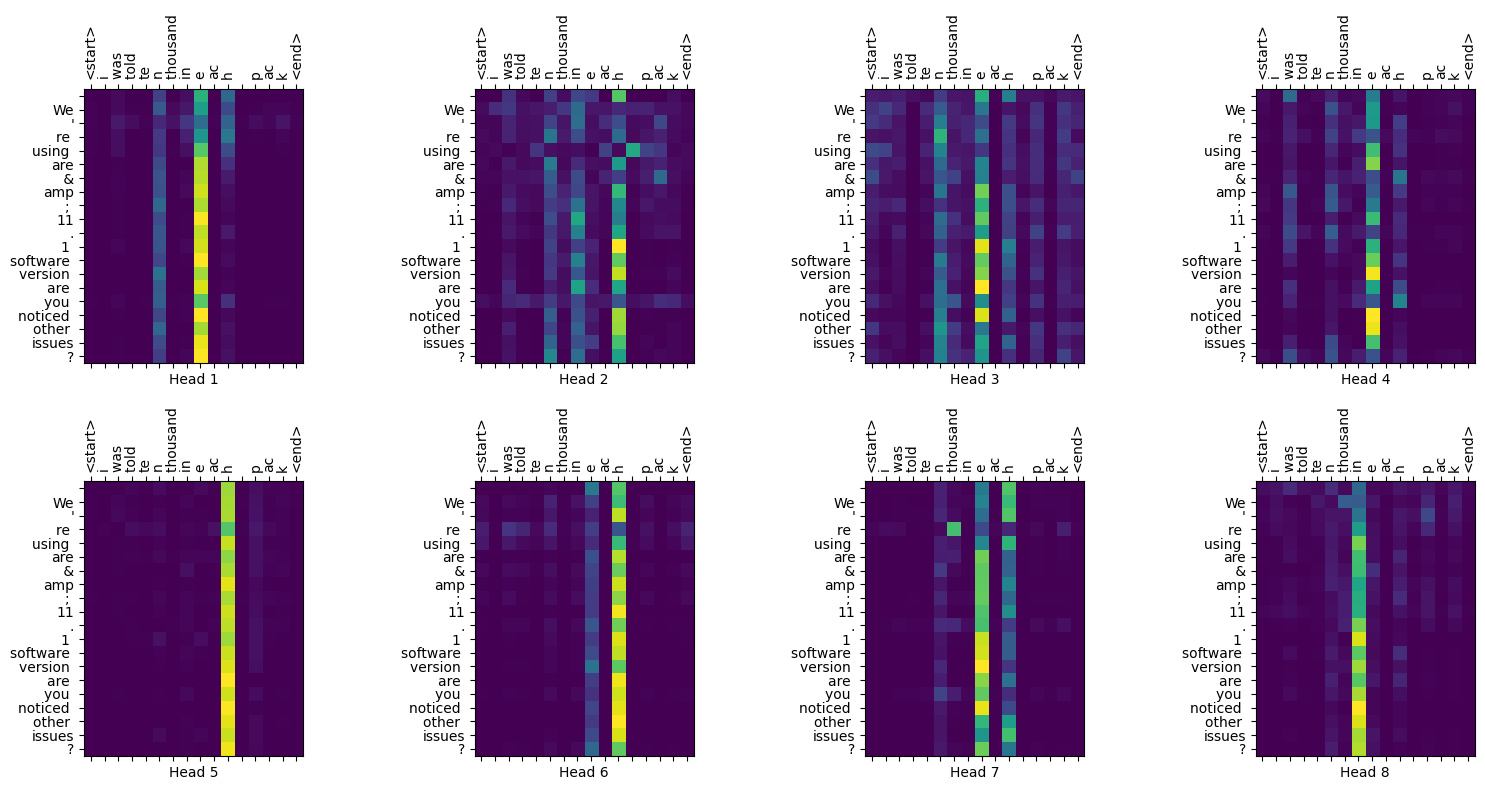

('i was told ten thousand in each pack',
 " We're using are &amp; 11.1 software version are you noticed other issues?")

In [ ]:
inp_sentence = "i was told ten thousand in each pack"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a, "decoder_layer2_block2")

* Results are great, better than encoder-decoder with bahadenau attention mechanism
* Still we can see the results are not perfect, because the architecture has less parameters plus the dataset is not very big and transformers works close to humans with large data and large trainable parameters

# On random inputs!
### Results are genuine

In [ ]:
inp_sentence = "hi"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a)


Got end token
Input: hi
Predicted translation:  Let'll continue for ways gt; General &ampfor our like out for our like gt; with?


('hi',
 " Let'll continue for ways gt; General &ampfor our like out for our like gt; with?")

In [ ]:
inp_sentence = "Where have you been"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a)


Got end token
Input: Where have you been
Predicted translation:  We'd like to assist. Reach out to us in DM and we'll continue assistance.


('Where have you been',
 " We'd like to assist. Reach out to us in DM and we'll continue assistance.")

#### Making sense haha : ) "who are you"

In [ ]:
inp_sentence = "who are you"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a)


Input: who are you
Predicted translation:  We're happy to help in your phone confirm by for issues after There having. Please DM us what're eager to offer 


('who are you',
 " We're happy to help in your phone confirm by for issues after There having. Please DM us what're eager to offer ")

####  Again making sense "where do you live"

In [ ]:
inp_sentence = "where do you live"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a)

Input: where do you live
Predicted translation:  We can your iPhone where screenshotsyour iPhone? Which us your screenshotsSOS calls? Which watching tell us whaton your tell us what


('where do you live',
 ' We can your iPhone where screenshotsyour iPhone? Which us your screenshotsSOS calls? Which watching tell us whaton your tell us what')

In [ ]:
inp_sentence = "what is your name"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a)

Input: what is your name
Predicted translation:  Thanksconfirm reset those stepsreset those stepsreset those SOS detailSOS detaillike to clarifySOS Settings &gtvia those stepsthose steps


('what is your name',
 ' Thanksconfirm reset those stepsreset those stepsreset those SOS detailSOS detaillike to clarifySOS Settings &gtvia those stepsthose steps')

In [ ]:
inp_sentence = "why are you angry with me is there anything i did wrong"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a)

Input: why are you angry with me is there anything i did wrong
Predicted translation:  We're very welcome. So version of Let tell us 2 ID view running? You can found under Settings &amp; General


('why are you angry with me is there anything i did wrong',
 " We're very welcome. So version of Let tell us 2 ID view running? You can found under Settings &amp; General")